# DKTC Test

In [1]:
!nvidia-smi

Mon Oct  7 00:09:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DistilBertForSequenceClassification, AdamW
from transformers import pipeline

from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [3]:
# 한글 깨짐 방지

import platform

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

# Mac
elif os == 'Darwin':
    plt.rc('font', family= 'AppleGothic')

# Linux
elif os == 'Linux':
    plt.rc('font', family= 'NanumGothic')

else:
    print(f'{os} is not set')

### 데이터 로드 및 전처리
1. 형태소 분석기
2. 불용어 리스트
3. 구두점 처리

In [4]:
train_data_path ="/aiffel/aiffel/aiffel_dlthon_c2/data/new_train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
train_data['conversation'].head(5)

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

In [6]:
data = train_data.copy()

In [7]:
test_data_path ="/aiffel/aiffel/aiffel_dlthon_c2/data/new_train.csv"
test_data = pd.read_csv(test_data_path)
test_data.head(5)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [8]:
test_data = test_data.drop(test_data.columns[1], axis=1)

In [9]:
test_data.head(5)

,idx,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [10]:
test = test_data.copy()

In [11]:
len(data)

12092

In [12]:
len(test)

12092

In [13]:
from sklearn.preprocessing import LabelEncoder

# train 데이터셋의 'class_label' 컬럼을 라벨 인코딩
label_encoder = LabelEncoder()

# 'class_label' 열에 인코딩을 적용하여 숫자로 변환
data['class'] = label_encoder.fit_transform(data['class'])

# 변환된 데이터 확인
print(data['class'].head())

0    4
1    4
2    1
3    0
4    0
Name: class, dtype: int64


In [14]:
!pip install konlpy # 형태소 분석
!pip install packages

In [15]:
from konlpy.tag import Okt

# 형태소 분석기와 불용어 목록 정의
okt = Okt()

# 불용어 리스트 정의 (필요에 따라 확장 가능)
stopwords = ["이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"]

# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower()     # 1. 소문자 변환 (한국어에는 큰 영향을 미치지 않지만 영문 대비용)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # 2. 구두점 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)    # 3. 중복된 공백 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]+", " ", sentence)    # 4. 한글과 구두점 이외의 문자 제거
    sentence = re.sub(r"\s+", " ", sentence)

    tokens = okt.morphs(sentence, stem=True)     # 5. 형태소 분석-어간추출

    tokens = [word for word in tokens if word not in stopwords]    # 6. 불용어 제거

    sentence = " ".join(tokens)    # 7. 최종 문장 생성
    sentence = sentence.strip()    # 8. 좌우 공백 제거

    return sentence

# 전처리 적용
data['conversation'] = data['conversation'].apply(preprocess_sentence)
test['conversation'] = test['conversation'].apply(preprocess_sentence)



# 전처리된 데이터 확인
print(data['conversation'].head())
print(test['conversation'].head())

0    지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1    길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2    너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3    어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4    저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...
Name: conversation, dtype: object
0    지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1    길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2    너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3    어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4    저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...
Name: conversation, dtype: object


In [16]:
data['conversation'].head(5)

0    지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1    길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2    너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3    어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4    저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...
Name: conversation, dtype: object

In [17]:
# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})
data

,idx,class_label,conversation
0,0,4,지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1,1,4,길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2,2,1,너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3,3,0,어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4,4,0,저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...
...,...,...,...
12087,12087,2,미안하다 . . . 나 내일 회사 하루 쉬다 . 회사 ? 어 . . . 너무 힘들다...
12088,12088,2,아 엄마 뭐 하다 오밤중 ? 난 정말 나가다 . 애 처럼 왜 이르다 ? 동네 창피하...
12089,12089,2,"니 방 들어가다 , 자 임마 . 엄마 갑자기 짐 들다 사라지다 불안하다 못 나가다 ..."
12090,12090,2,"어 , 왜 일어나다 ? 힘드다 눕다 . 아니다 , 젠 괜찮다 오빠 . 뭐 괜찮다 ?..."


### 데이터프레임 인덱싱
1. conversation 컬럼이 결측치인지 확인
2. 결측치인 데이터만 뽑아내기
3. 결측치인 데이터의 개수를 세기

In [18]:
null_check = pd.isnull(data['conversation'])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
12087    False
12088    False
12089    False
12090    False
12091    False
Name: conversation, Length: 12092, dtype: bool


In [19]:
null_data = data.loc[null_check, 'conversation']
null_data.head()

Series([], Name: conversation, dtype: object)

In [20]:
print(f'id: {len(null_data.values)}')

id: 0


In [21]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

idx : 0
class_label : 0
conversation : 0


## 데이터 그래프 시각화
class당 각 대화의 개수와 길이를 확인해보자

### 대화 개수 히스토그램
Class별 Conversation 개수 확인

결과: 확실히 일반 컬럼의 데이터 개수가 가장 많은 것으로 볼 수 있다.
다른 클래스들은 1000개 정도 까지 분포되어 있다는 것을 확인

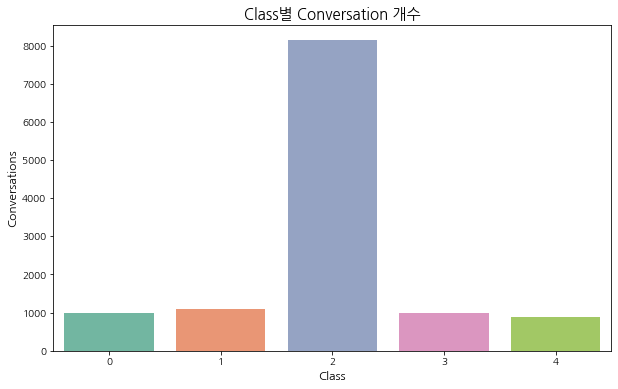

In [22]:
class_counts = data['class_label'].value_counts().reset_index()
class_counts.columns = ['class_label', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class_label', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

### 대화 길이 분포 히스토그램
현재 class당 텍스트의 길이를 측정

결과: 다른 클래스 보다 일반 클래스의 대화 길이가 가장 평균적으로 낮았다.

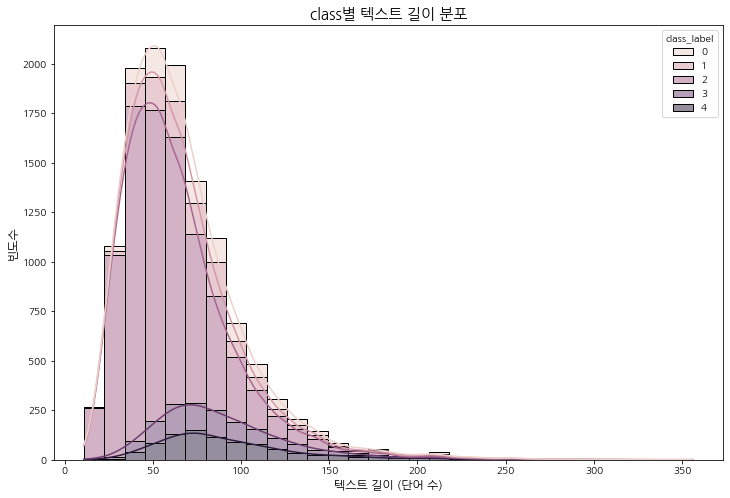

In [23]:
data['text_length'] = data['conversation'].apply(lambda x: len(x.split()))

# 카테고리별 텍스트 길이 분포를 시각화하는 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='text_length', hue='class_label', multiple="stack", bins=30, kde=True)
plt.title('class별 텍스트 길이 분포', fontsize=15)
plt.xlabel('텍스트 길이 (단어 수)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.show()


## 업샘플링
데이터의 불균형을 초래할 수 있기에 다른 클래스의 데이터 분포와 같이 조정

In [24]:
group_counts = data['class_label'].value_counts()
number_min_label = min(group_counts)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [25]:
data = data.groupby("class_label").sample(number_min_label, random_state = 200)
data.groupby("class_label").count().iloc[:,0]

class_label
0    896
1    896
2    896
3    896
4    896
Name: idx, dtype: int64

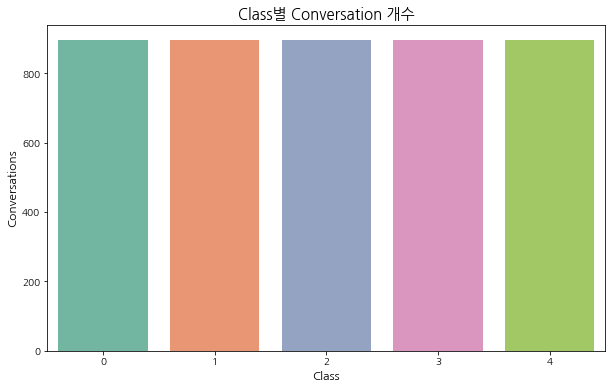

In [26]:
class_counts = data['class_label'].value_counts().reset_index()
class_counts.columns = ['class_label', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class_label', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

In [27]:
# 길이 분포 출력
conversation_len = [len(s.split()) for s in data['conversation']]
class_label_len = [len(s.split()) for s in data['class_label']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

AttributeError: 'int' object has no attribute 'split'

In [28]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 400
print(MAX_LENGTH)

400


In [29]:
!pip install transformers torch

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# KoELECTRA 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

# KoELECTRA 분류 모델 로드 (num_labels는 클래스의 수에 맞춰 설정)
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=5).to("cuda")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [31]:
# 예시 데이터 준비 (train 데이터는 'conversation' 컬럼과 'class' 레이블로 이루어져 있다고 가정)
train_texts = data['conversation'].tolist()
train_labels = data['class_label'].tolist()

test_texts = test['conversation'].tolist()

# 텍스트 데이터를 토큰화
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# train 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)

# test 데이터셋 생성 (라벨이 없으므로 labels=None)
test_dataset = CustomDataset(test_encodings)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [33]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용해 라벨을 숫자로 변환
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(data['class_label'].tolist())

In [ ]:
from sklearn.metrics import accuracy_score

model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=5).to("cuda")

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 루프
model.train()

epochs = 3  # 학습할 에포크 수

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0  # 정확도를 계산하기 위한 변수
    total_samples = 0  # 전체 샘플 수
    
    for batch in train_loader:
        optimizer.zero_grad()  # 기울기 초기화

        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['labels'].to("cuda")
        
        # 모델에 데이터 입력하여 손실 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits  # 예측값 (logits)
        
        # 역전파 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # 예측값에서 가장 높은 확률을 가진 클래스를 선택 (logits를 클래스 번호로 변환)
        preds = torch.argmax(logits, dim=-1)
        
        # 실제 라벨과 예측 라벨을 비교하여 맞춘 개수를 계산
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples  # 전체 정확도 계산

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")

In [35]:
from sklearn.metrics import f1_score, accuracy_score

model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=5).to("cuda")

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 루프
epochs = 10  # 학습할 에포크 수

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    all_preds = []
    all_labels = []

    # 학습 데이터에 대한 루프
    for batch in train_loader:
        optimizer.zero_grad()  # 기울기 초기화

        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['labels'].to("cuda")
        
        # 모델에 데이터 입력하여 손실 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # 역전파 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # 예측값 저장
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())  # GPU -> CPU로 데이터를 이동하여 numpy 배열로 변환
        all_labels.extend(labels.cpu().numpy())  # 실제 라벨도 저장
    
    avg_loss = total_loss / len(train_loader)

    # F1 스코어 계산
    f1 = f1_score(all_labels, all_preds, average='weighted')  # 클래스 비율에 따른 가중 평균
    
    # 정확도 계산
    accuracy = accuracy_score(all_labels, all_preds)  # 실제 라벨과 예측 라벨을 비교하여 정확도 계산

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - F1 Score: {f1:.4f}")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Epoch 1/10 - Loss: 0.8125 - Accuracy: 0.7116 - F1 Score: 0.7130
Epoch 2/10 - Loss: 0.3311 - Accuracy: 0.9022 - F1 Score: 0.9021
Epoch 3/10 - Loss: 0.2214 - Accuracy: 0.9379 - F1 Score: 0.9379
Epoch 4/10 - Loss: 0.1558 - Accuracy: 0.9574 - F1 Score: 0.9573
Epoch 5/10 - Loss: 0.1176 - Accuracy: 0.9661 - F1 Score: 0.9661
Epoch 6/10 - Loss: 0.0961 - Accuracy: 0.9741 - F1 Score: 0.9741
Epoch 7/10 - Loss: 0.0733 - Accuracy: 0.9810 - F1 Score: 0.9810
Epoch 8/10 - Loss: 0.0595 - Accuracy: 0.9842 - F1 Score: 0.9842
Epoch 9/10 - Loss: 0.0703 - Accuracy: 0.9810 - F1 Score: 0.9810
Epoch 10/10 - Loss: 0.0590 - Accuracy: 0.9850 - F1 Score: 0.9850


In [38]:
import numpy as np
import pandas as pd
import torch

# KoELECTRA 모델을 평가 모드로 전환
model.eval()

predictions = []

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 가장 높은 확률을 가진 클래스를 예측
        preds = torch.argmax(logits, dim=-1)

        # 예측값을 리스트에 저장
        predictions.extend(preds.cpu().numpy())

# 예측값을 500개로 제한
predictions = predictions[:500]  # 500개의 예측값만 자름

# 예측 결과를 CSV로 저장
def save_predictions_to_csv(predictions, filename="koelectra_predictions.csv"):
    # 예측값이 정확히 500개인지 확인
    if len(predictions) != 500:
        raise ValueError("예측값의 길이는 500이어야 합니다.")

    # 예측 결과를 DataFrame으로 변환, ID는 t_000 ~ t_499 형식으로 생성
    submission_df = pd.DataFrame({
        'idx': [f't_{i:03}' for i in range(len(predictions))],  # 't_000' ~ 't_499' 형식의 ID
        'target': predictions  # 예측값을 열로 추가
    })

    # CSV 파일로 저장 (Jupyter Notebook 환경에서는 파일을 로컬에 저장)
    submission_df.to_csv(filename, index=False)

    # 저장 완료 메시지
    print(f'{filename} saved!')

# 예측값을 CSV로 저장
save_predictions_to_csv(predictions, filename="koelectra_predictions.csv")

koelectra_predictions.csv saved!
